In [0]:
#@title 小波神经网络 { display-mode: "both" }
# 程序实现包含一个小波隐藏层的小波神经网络,小波函数为 POLYWOG3 函数
# 该小波神经网络无论是收敛速度，还是拟合能力能力都比含双隐层的普通神经网络要强
# 详见 NN.py，NN.ipynb，Wavelet_NN.py 和 Wavelet_NN.ipynb
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
from numpy.linalg import norm
import numpy as np 
import time

In [0]:
# 计时装饰器
def timer(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        func(*args, **kwargs)
        end_time = time.time()
        print('Training time is :{:.2f} s.'.format(end_time - start_time))
    return wrapper

## 定义网络结构类

In [0]:
class WaveletNeuralNet(object):
    # 初始化神经网络，sizes是神经网络的层数和每层神经元个数  
    def __init__(self, sizes, k, name='morlet wavelet'):
        self.sizes_ = sizes
        self.num_layers_ = len(sizes)  # 层数
        if self.num_layers_ > 3:
            print('ERROR!')
        self.num_nuerals_ = sizes[1]
        self.w_ = [np.random.randn(y, x) for x, y in zip(sizes[:-1], sizes[1:])]  # w_、b_初始化为正态分布随机数
        self.b_ = [np.random.randn(y, 1) for y in sizes[1:]]
        self.t_ = np.random.randint(2, 15, (self.num_nuerals_, 1))
#         self.t_ = np.random.normal(5, 2., (self.num_nuerals_, 1))
        self.s_ = 2 * np.random.randn(self.num_nuerals_, 1)
        self.k = k
        if name == 'morlet wavelet' or name == 'POLYWOG3 wavelet':
            self.name = name
        else: self.err_print()
    
    # 错误打印
    def err_print(self):
        print("Unsupported wavelet!\nOnly support 'morlet wavelet' and 'POLYWOG3 wavelet'.")
    
    # 标签转化
    def one_hot(self, x, num_classes):
        x = x.flatten().astype('uint8')
        m = x.shape[0]
        x_onehot = np.zeros((m, num_classes))
        for i in range(m):
            x_onehot[i, x[i]] = 1
        return x_onehot
        
    # Sigmoid函数，S型曲线，
    def sigmoid(self, z):
        return 1.0 / (1.0 + np.exp(-z))
    
    # Sigmoid函数的导函数
    def sigmoid_der(self, z):
        return self.sigmoid(z) * (1 - self.sigmoid(z))
    
    # morlet小波母函数
    def phi(self, z, t=1, s=0):
        k = self.k
        z_ = (z - s) / t
        return np.cos(k * z_) * np.exp(-z_**2 / 2.)
    
    # 小波函数导数
    def phi_der(self, z, t=1, s=0):
        k = self.k
        z_ = (z - s) / t
        return (-k * np.sin(k * z_) * np.exp(-z_**2 / 2) - z_ * np.cos(k * z_) * np.exp(-z_**2 / 2)) / t
    
    # POLYWOG3 小波母函数
    def polywog3(self, z, t=1, s=0):
        k = self.k
        z_ = (z - s) / t
        c_exp = np.exp(-.5 * np.power(z_, 2))
        return k * (np.power(z_, 4) - 6 * np.power(z_, 2) + 3) * c_exp
    
    # POLYWOG3 小波导函数
    def polywog3_der(self, z, t=1, s=0):
        k = self.k
        z_ = (z - s) / t
        c_exp = np.exp(-.5 * np.power(z_, 2))
        return k * (10 * np.power(z_, 3) - np.power(z_, 5) - 15 * z_) * c_exp

    def feedforward(self, x): # 前向
        if self.name == 'morlet wavelet':
            func = self.phi
        elif self.name == 'POLYWOG3 wavelet':
            func = self.polywog3
        else: self.err_print()
        n = self.w_[0].shape[1]
        x = x.reshape(n, -1)
        x1 = func(np.dot(self.w_[0], x) + self.b_[0], self.t_, self.s_)
        x2 = self.sigmoid(np.dot(self.w_[1], x1) + self.b_[1])
        return x2
    
    # 反向传播
    def backprop(self, x, y):
        if self.name == 'morlet wavelet':
            func = self.phi
            func_der = self.phi_der
        elif self.name == 'POLYWOG3 wavelet':
            func = self.polywog3
            func_der = self.polywog3_der
        else: self.err_print()
        b_new = [np.zeros(b.shape) for b in self.b_]
        w_new = [np.zeros(w.shape) for w in self.w_]
        t_new = self.t_
        s_new = self.s_
        activation = x
        activations = [x]  # activations代表着每层的输出
        zs = []  # zs代表着每层的输入，即前层输出与权重的和
        z = np.dot(self.w_[0], activation) + self.b_[0]
        zs.append(z)
        activation = func(z, t_new, s_new)
        activations.append(activation)
        z = np.dot(self.w_[1], activation) + self.b_[1]
        zs.append(z) 
        activation = self.sigmoid(z)
        activations.append(activation)
        
        delta = self.cost_derivative(activations[-1], y) * self.sigmoid_der(zs[-1])
        b_new[-1] = delta
        w_new[-1] = np.dot(delta, activations[-2].transpose())
        
        delta_last = delta.copy()
        z = zs[-2]
        sp = func_der(z, t_new, s_new)
        delta = np.dot(self.w_[-1].transpose(), delta_last) * sp
        b_new[-2] = delta
        w_new[-2] = np.dot(delta, activations[-3].transpose())
        sp_t = -.5 * t_new**-1.5 * func((z-s_new) / t_new) - t_new**-2.5 * (z - s_new) * func_der((z - s_new) / t_new)
        sp_s = -t_new**-1.5 * func_der((z-s_new) / t_new)
        # t_new = np.dot(self.w_[-1].transpose(), delta_last)*sp_t # loss函数对小波函数缩放系数的偏导
        # s_new = np.dot(self.w_[-1].transpose(), delta_last)*sp_s # loss函数对小波函数平移系数的偏导
        
        t_new = delta * sp_t # loss函数对小波函数缩放系数的偏导
        s_new = delta * sp_s # loss函数对小波函数平移系数的偏导
        
        return (b_new, w_new, t_new, s_new)

    # 更新权值w，偏移b，缩放因子t，偏移因子s
    def update_mini_batch(self, mini_batch, lr):
        b_new = [np.zeros(b.shape) for b in self.b_]
        w_new = [np.zeros(w.shape) for w in self.w_]
        a, b = mini_batch[:, :-1], self.one_hot(mini_batch[:, -1], num_classes=10)
        n = np.float(mini_batch.shape[0])
        for i in range(int(n)):
            x, y = a[i, :].reshape(-1, 1), b[i, :].reshape(-1, 1)
            delta_b_new, delta_w_new, t_new, s_new = self.backprop(x, y)
            b_new = [nb + dnb for nb, dnb in zip(b_new, delta_b_new)]
            w_new = [nw + dnw for nw, dnw in zip(w_new, delta_w_new)]
        self.w_ = [w - lr * nw for w, nw in zip(self.w_, w_new)]
        self.b_ = [b - lr * nb for b, nb in zip(self.b_, b_new)]
        self.t_ = self.t_ - lr * t_new
        self.s_ = self.s_ - lr * s_new
    
    # training_data是训练数据(x, y), epochs是训练次数, mini_batch_size是每次训练样本数, lr是learning rate，step是展示的迭代间隔
    @timer
    def SGD(self, training_data, epochs=50, mini_batch_size=32, lr=.1, step=10):
        assert type(step) == int, 'Step must be a integer.'
    
        n = training_data[0].shape[0]
        for j in range(epochs):
            ss = np.hstack((training_data[0],training_data[1].reshape(n, -1)))
            np.random.shuffle(ss)
            mini_batches = [ss[k:k + mini_batch_size, :] for k in range(0, n, mini_batch_size)]
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, lr)
            accur = self.evaluate(training_data) * 100
            mse_loss = self.mse_loss(training_data)
            if (j + 1) % step == 0 or j == 0:
                print("Epoch {0}, mse_loss: {1:.4f}, accury on the training set :{2:.2f}{3}".format(j+1, mse_loss, accur, '%'))
            # print("Epoch {0}: {1} / {2}".format(j, self.evaluate(training_data), n))
    
    # 计算正确率
    def evaluate(self, data):
        x_t, x_label = data
        test_results = [(np.argmax(self.feedforward(x)), y) for (x, y) in zip(list(x_t), list(x_label))]
        acc = sum(int(x == y) for (x, y) in test_results) / x_t.shape[0]
        return acc
    
    # mse_loss的导数
    def cost_derivative(self, output_activations, y):
        return (output_activations - y)
    
    # mse_loss
    def mse_loss(self, training_data):
        x_t,x_label = training_data
        test_results = [.5 * norm(self.feedforward(x).flatten() - self.one_hot(y, num_classes=10))**2
                        for (x, y) in zip(list(x_t), list(x_label))]
        return np.array(test_results).mean()
    
    # 预测
    def predict(self, data):
        data = data.reshape(-1, self.sizes_[0])
        value = np.array([np.argmax(net.feedforward(x)) for x in data], dtype='uint8')
        return value
    
    # 保存训练模型
    def save(self):
        pass  # 把_w和_b保存到文件(pickle)  
    
    def load(self):
        pass

## 主程序区

In [0]:
mnist = input_data.read_data_sets('./MNIST_data', one_hot=False)

Extracting ./MNIST_data/train-images-idx3-ubyte.gz
Extracting ./MNIST_data/train-labels-idx1-ubyte.gz
Extracting ./MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ./MNIST_data/t10k-labels-idx1-ubyte.gz


In [0]:
num_classes = 10
training_data = mnist.train.next_batch(5000)
testing_data = mnist.test.next_batch(1000)
net = WaveletNeuralNet([784, 128, num_classes], k=1.75, name='symlets wavelet')


Unsupported wavelet!
Only support 'morlet wavelet' and 'POLYWOG3 wavelet'.


### Morlet wavelet

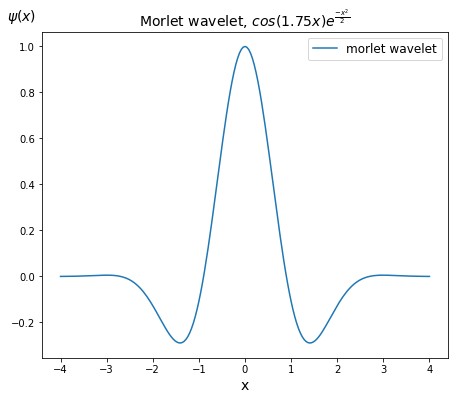

In [0]:
# Morlet wavelet
net = WaveletNeuralNet([784, 128, num_classes], k=1.75, name='morlet wavelet')
title_name = net.name.capitalize() + r', $cos(%.2fx)e^{\frac{-x^{2}}{2}}$' % net.k
fig = plt.figure(1, figsize=(16, 6))
ax = fig.add_subplot(121)
x = np.linspace(-4, 4, 201, endpoint=True)
y = net.phi(x, t=1, s=0)
ax.plot(x, y, label='morlet wavelet')
ax.legend(loc='upper right', fontsize=12)
ax.set_title(title_name, fontsize=14)
ax.set_xlabel('x', fontsize=14)
ax.set_ylabel(r'$\psi (x)$', rotation='horizontal', fontsize=14)
ax.yaxis.set_label_coords(-.05,1.02)

# # Derivative function
# y_d = net.phi_der(x, t=1, s=0)
# ax_d = fig.add_subplot(122)
# ax_d.plot(x, y_d, label='derivative')
# ax_d.legend(loc='upper right', fontsize=12)
# ax_d.set_title('Derivative of morlet wavelet', fontsize=14)
# ax_d.set_xlabel('x', fontsize=14)
# ax_d.set_ylabel("${\psi}'(x)$", rotation='horizontal', fontsize=14)
# ax_d.yaxis.set_label_coords(-.05,1.02)


In [0]:
net.SGD(training_data, epochs=200, mini_batch_size=32, lr=.1, step=20)

Epoch 1, mse_loss: 0.3483, accury on the training set :48.18%
Epoch 20, mse_loss: 0.0474, accury on the training set :93.06%
Epoch 40, mse_loss: 0.0246, accury on the training set :95.72%
Epoch 60, mse_loss: 0.0198, accury on the training set :96.48%
Epoch 80, mse_loss: 0.0170, accury on the training set :96.86%
Epoch 100, mse_loss: 0.0160, accury on the training set :96.96%
Epoch 120, mse_loss: 0.0153, accury on the training set :97.12%
Epoch 140, mse_loss: 0.0143, accury on the training set :97.28%
Epoch 160, mse_loss: 0.0139, accury on the training set :97.38%
Epoch 180, mse_loss: 0.0135, accury on the training set :97.44%
Epoch 200, mse_loss: 0.0133, accury on the training set :97.54%
Training time is :1207.57 s.


In [0]:
net.t_.flatten()

array([ 4.99904269,  6.00022797, 11.99995034,  8.99848716,  3.00845948,
        5.00409558,  7.99924318,  4.00407966, 10.99975776, 11.99924033,
        8.99934667,  4.00201413,  9.99976473,  8.9995115 ,  4.00008866,
       13.99980639, 13.00003856,  9.0009621 , 11.00041398, 13.99988086,
       10.00038308,  7.99936678,  2.02555637,  8.0002758 ,  2.99387556,
       14.00012857,  6.99888334,  4.00268643,  5.99948328,  6.00323298,
        7.00054296,  2.00134477,  4.00019851,  8.00020665, 14.00012298,
       13.99990757,  3.99947252, 11.00026759,  2.99586741, 10.0002837 ,
        8.99986365, 11.99970767,  2.0054495 ,  7.99956412, 11.99953559,
       12.00041056,  2.00322634,  1.99050182, 10.99943135,  2.99562374,
        5.99949241, 10.00045159,  7.0001492 ,  2.99589506,  4.0083368 ,
        3.99903764, 12.99983576,  4.00301323,  9.99908899, 13.0003612 ,
        7.00152985,  3.00157538,  1.99105747,  6.00098485, 12.99979426,
       11.00041961,  3.00052383,  2.0065291 ,  4.9990849 ,  5.99

In [0]:
net.s_.flatten()

array([-0.92115177,  2.18530712,  1.15126992,  0.86747258, -1.02541869,
       -0.46189893,  3.06042623, -0.27319103,  0.67177635, -2.47916003,
        1.77805865, -3.08542663,  0.44233331,  0.91506476,  1.51826505,
        4.00120189, -1.47045046, -1.52280707, -1.62415848, -1.42507351,
        0.99558615, -3.59305782, -0.29736646,  3.15593382, -0.22218867,
       -1.66824846, -2.11551312, -1.5550711 ,  0.81505449, -3.40314958,
       -0.96629152, -1.75348558, -0.61763233, -5.44751733,  0.17835381,
       -1.38351523, -1.30437939,  0.58033237, -2.37478341,  1.5926276 ,
       -0.16087862,  2.75929751, -3.76529068, -0.43212847, -1.87020057,
        1.39765048, -0.04483065,  1.89552031,  2.6806809 , -2.16734589,
        2.07694254,  0.0772893 , -1.20026636,  0.62674306,  1.23422939,
       -1.52437945,  0.92174494, -1.59191911,  3.29589727,  2.12378314,
        0.4828541 , -0.02729154,  0.33672844, -7.02227248,  1.6520183 ,
       -3.61414446, -0.27367497, -5.67103934,  0.0689861 ,  2.64

### POLYWOG3 wavelet

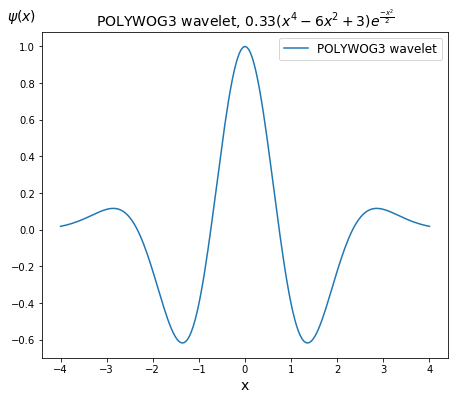

In [0]:
# POLYWOG3 wavelet
net = WaveletNeuralNet([784, 128, num_classes], k=1. / 3, name='POLYWOG3 wavelet')
title_name = net.name + r', $%.2f(x^{4}-6x^{2}+3)e^{\frac{-x^{2}}{2}}$' % net.k
fig = plt.figure(2, figsize=(16, 6))
ax = fig.add_subplot(121)
x = np.linspace(-4, 4, 201, endpoint=True)
y = net.polywog3(x, t=1, s=0)
ax.plot(x, y, label='POLYWOG3 wavelet')
ax.legend(loc='upper right', fontsize=12)
ax.set_title(title_name, fontsize=14)
ax.set_xlabel('x', fontsize=14)
ax.set_ylabel(r'$\psi (x)$', rotation='horizontal', fontsize=14)
ax.yaxis.set_label_coords(-.05,1.02)

# # Derivative function
# y_d = net.polywog3_der(x, t=1, s=0)
# ax_d = fig.add_subplot(122)
# ax_d.plot(x, y_d, label='derivative')
# ax_d.legend(loc='upper right', fontsize=12)
# ax_d.set_title('Derivative of POLYWOG3 wavelet', fontsize=14)
# ax_d.set_xlabel('x', fontsize=14)
# ax_d.set_ylabel("${\psi}'(x)$", rotation='horizontal', fontsize=14)
# ax_d.yaxis.set_label_coords(-.05,1.02)

In [0]:
net.SGD(training_data, epochs=200, mini_batch_size=32, lr=.1, step=20)

Epoch 1, mse_loss: 0.2867, accury on the training set :63.04%
Epoch 20, mse_loss: 0.0103, accury on the training set :98.26%
Epoch 40, mse_loss: 0.0071, accury on the training set :98.76%
Epoch 60, mse_loss: 0.0060, accury on the training set :98.90%
Epoch 80, mse_loss: 0.0053, accury on the training set :99.00%
Epoch 100, mse_loss: 0.0048, accury on the training set :99.08%
Epoch 120, mse_loss: 0.0047, accury on the training set :99.10%
Epoch 140, mse_loss: 0.0047, accury on the training set :99.10%
Epoch 160, mse_loss: 0.0043, accury on the training set :99.22%
Epoch 180, mse_loss: 0.0039, accury on the training set :99.26%
Epoch 200, mse_loss: 0.0038, accury on the training set :99.26%
Training time is :1379.53 s.


In [0]:
net.t_.flatten()

array([ 7.006533  , 10.99821939,  4.99616006,  2.9791689 , 12.98283851,
        2.99052947,  4.99826786,  5.00988135,  4.99755199, 13.00851659,
        3.97232528, 11.00675587,  6.99457377,  2.99533366,  7.9983703 ,
       11.99059049,  3.97826579,  9.01439728, 11.99934677, 13.99402882,
       12.00679338, 12.00452163,  6.98801663,  5.99281714,  6.01757831,
        5.00270234,  4.01097045,  3.98989553,  7.99995749,  3.00804661,
        1.97285264,  8.00063724,  7.01059148,  2.00543699, 10.00201019,
        3.99029511, 10.0128009 ,  9.99572246,  8.99884431,  7.98132087,
        4.99626748,  8.01663692, 10.9984154 , 12.98696756,  4.99884721,
        4.99768137,  7.99595167, 12.00651274, 11.00056882, 11.99479923,
       10.02030522,  6.01084777, 13.00622337,  5.99319332, 11.97779517,
        4.00357177,  6.99890936,  8.01928657,  6.99312304,  6.01406871,
        8.98252058, 12.01495348,  5.00124034, 12.99185452,  7.9988854 ,
        7.98881813, 13.99294747,  9.00247114,  5.00459135,  7.01

In [0]:
net.s_.flatten()

array([ 1.69078169, -0.94731311,  1.81262287,  1.39854854, -1.48809052,
       -0.64928608, -4.40759712,  0.54702484,  2.82927973,  2.23783439,
       -0.78515397, -0.153847  , -1.44210814, -0.84367117,  1.51230069,
       -0.15389474, -2.44228297, -0.75770724, -3.04624246,  0.21299283,
       -2.09016126,  0.03466409,  0.43273872,  0.12276943, -1.64693112,
       -1.5864839 ,  1.36910203,  4.1783622 , -1.71889865, -0.17325525,
       -1.25193395,  1.93352573,  1.02610157, -0.20891111,  0.17313031,
        3.34605656,  0.95444837, -4.95573879, -1.66784311,  1.48859239,
        0.13458239,  0.34821283,  0.51709586,  2.40062792,  2.7874017 ,
       -2.71262164, -1.79974683,  0.16314681, -3.64827868, -2.50643986,
       -0.83449318, -0.65704063, -0.2491729 , -4.78542567,  1.16903189,
       -0.69947379, -1.46128882, -1.72029912,  1.42500123, -2.47052411,
       -2.13289448, -3.49458722, -0.87521292,  2.8906986 , -2.19667075,
       -2.41800709,  2.41579209, -3.13406417,  2.63326179, -0.19

## 验证区

In [0]:
# testing_data = mnist.test.next_batch(1000)
net.evaluate(testing_data)

0.936


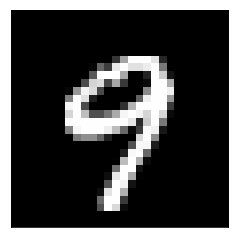

In [0]:
plt.imshow(training_data[0][10].reshape(28,-1), 'gray')
plt.xticks([]), plt.yticks([])
plt.show()

In [0]:
training_data[1][10]

9

In [0]:
net.predict(training_data[0][10])

array([9], dtype=uint8)